In [4]:
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
tfd = tfp.distributions
tfb = tfp.bijectors
vi = tfp.vi

import matplotlib.pyplot as plt
from bakeoff.TensorFlow_Prob.run_tfp import make_conditioned_lp

In [ ]:
mu_prior, sigma_prior = 0, 10
sigma_like = 1.0
max_iters = 1_600_000
target_log_prob_fn = make_conditioned_lp(
  prior_dist = tfd.Normal(mu_prior, sigma_prior),
  likelihood_dist = lambda z: tfd.Normal(z, sigma_like),
  x = np.array([])
)
q_loc = tf.Variable(0.0, name=f'q_loc', dtype=np.float32)
q_scale = tf.Variable(10.0, name=f'q_scale', dtype=np.float32)
surrogate_posterior = tfd.Normal(loc=q_loc, scale=q_scale)

q_loc_2 = tf.Variable(0.0, name=f'q_loc_2', dtype=np.float32)
q_scale_2 = tf.Variable(10.0, name=f'q_scale_2', dtype=np.float32)
surrogate_posterior_2 = tfd.Normal(loc=q_loc_2, scale=q_scale_2)


q_z_single = tfp.experimental.util.make_trainable(tfd.Normal, name='q_z')
q_z_multiple = tfp.experimental.util.make_trainable(tfd.Normal, name='q_z')

def trace_fn_single(traceable_quantities):
    return q_z_single.mean(), q_z_single.stddev(), traceable_quantities.loss

def trace_fn_multiple(traceable_quantities):
    return q_z_multiple.mean(), q_z_multiple.stddev(), traceable_quantities.loss

single_sample_losses = tfp.vi.fit_surrogate_posterior(
    target_log_prob_fn,
    seed=10,
    surrogate_posterior=q_z_single,
    trainable_variables=q_z_single.trainable_variables,
    optimizer=tf.optimizers.Adam(learning_rate=0.01, epsilon=1e-8),
    trace_fn= trace_fn_single,
    num_steps=max_iters
    )
multi_sample_losses = tfp.vi.fit_surrogate_posterior(
    target_log_prob_fn,
    seed=10,
    surrogate_posterior=q_z_multiple,
    trainable_variables=q_z_multiple.trainable_variables,
    optimizer=tf.optimizers.Adam(learning_rate=0.01, epsilon=1e-8),
    trace_fn= trace_fn_multiple,
    num_steps=max_iters,
    sample_size=100)


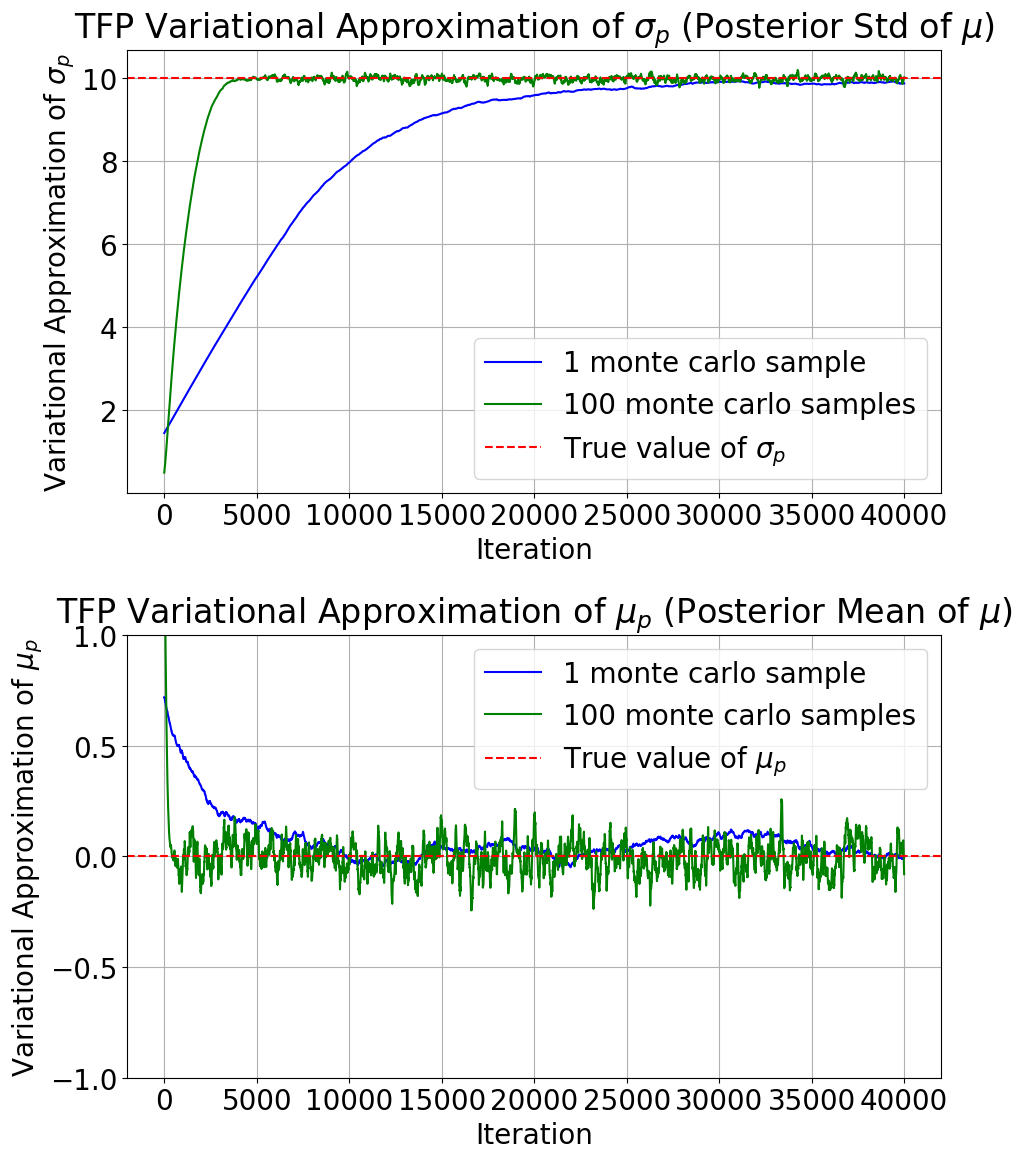

In [ ]:
# plot single_tracker vs multi_tracker for the mean and std of mu
# add dashed lines for true values of mu mean and std which is N(0, 1)
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2, 1, figsize=(10, 12))

# set font size to 14
plt.rcParams.update({'font.size': 20})

axs[1].plot(single_sample_losses[0], label='1 monte carlo sample', color='blue')
axs[1].plot(multi_sample_losses[0], label='100 monte carlo samples', color='green')
axs[1].axhline(mu_prior, color='red', linestyle='--', label=r'True value of $\mu_p$')
axs[1].set_title(r'TFP Variational Approximation of $\mu_p$ (Posterior Mean of $\mu$)')
axs[1].set_xlabel('Iteration')
axs[1].set_ylabel(r'Variational Approximation of $\mu_p$')
axs[1].legend()
axs[1].grid()

axs[0].plot(single_sample_losses[1], label='1 monte carlo sample', color='blue')
axs[0].plot(multi_sample_losses[1], label='100 monte carlo samples', color='green')
axs[0].axhline(sigma_prior, color='red', linestyle='--', label=r'True value of $\sigma_p$')
axs[0].set_title(r'TFP Variational Approximation of $\sigma_p$ (Posterior Std of $\mu$)')
axs[0].set_xlabel('Iteration', fontsize=20)
axs[0].set_ylabel(r'Variational Approximation of $\sigma_p$')
axs[0].legend()
axs[0].grid()
# axs[0].set_ylim(sigma_prior - 1, sigma_prior + 2)
axs[1].set_ylim(mu_prior - 1, mu_prior + 1)

plt.tight_layout()
plt.show()

# Appendix

First, 10 runs of TFP with different random seeds with its own defaults.

In [ ]:
def make_loc_scale(name_prefix):
    loc = tf.Variable(0.0, name=f'{name_prefix}_loc', dtype=np.float32)
    scale = tf.Variable(10.0, name=f'{name_prefix}_scale', dtype=np.float32)
    return tfd.Normal(loc=loc, scale=scale)
def return_trainable():
    return tfp.experimental.util.make_trainable(tfd.Normal, name='q_z')
def make_trace_fn(q_z):
    def trace_fn(traceable_quantities):
        return q_z.mean(), q_z.stddev(), traceable_quantities.loss
    return trace_fn

def fit_tfp_model(seed, q_z, adam_learning_rate=1e-3, adam_epsilon=1e-7, sample_size=1, num_iters=40_000):
    losses = tfp.vi.fit_surrogate_posterior(
        target_log_prob_fn,
        seed=seed,
        surrogate_posterior=q_z,
        trainable_variables=q_z.trainable_variables,
        optimizer=tf.optimizers.Adam(learning_rate=adam_learning_rate, epsilon=adam_epsilon),
        trace_fn= make_trace_fn(q_z),
        num_steps=num_iters,
        sample_size=sample_size)
    return losses

q_z_0_1 = return_trainable()
q_z_0_100 = return_trainable()
losses_0_1 = fit_tfp_model(0, q_z_0_1)
losses_0_100 = fit_tfp_model(0, q_z_0_100, sample_size=100)

In [18]:
q_z_1_1 = return_trainable()
q_z_1_100 = return_trainable()

losses_1_1 = fit_tfp_model(1, q_z_1_1)
losses_1_100 = fit_tfp_model(1, q_z_1_100, sample_size=100)

q_z_2_1 = return_trainable()
q_z_2_100 = return_trainable()
losses_2_1 = fit_tfp_model(2, q_z_2_1)
losses_2_100 = fit_tfp_model(2, q_z_2_100, sample_size=100)


q_z_3_1 = return_trainable()
q_z_3_100 = return_trainable()

losses_3_1 = fit_tfp_model(3, q_z_3_1)
losses_3_100 = fit_tfp_model(3, q_z_3_100, sample_size=100)

q_z_4_1 = return_trainable()
q_z_4_100 = return_trainable()
losses_4_1 = fit_tfp_model(4, q_z_4_1)
losses_4_100 = fit_tfp_model(4, q_z_4_100, sample_size=100)

q_z_5_1 = return_trainable()
q_z_5_100 = return_trainable()
losses_5_1 = fit_tfp_model(5, q_z_5_1)
losses_5_100 = fit_tfp_model(5, q_z_5_100, sample_size=100)

q_z_6_1 = return_trainable()
q_z_6_100 = return_trainable()
losses_6_1 = fit_tfp_model(6, q_z_6_1)
losses_6_100 = fit_tfp_model(6, q_z_6_100, sample_size=100)

q_z_7_1 = return_trainable()
q_z_7_100 = return_trainable()
losses_7_1 = fit_tfp_model(7, q_z_7_1)
losses_7_100 = fit_tfp_model(7, q_z_7_100, sample_size=100)

q_z_8_1 = return_trainable()
q_z_8_100 = return_trainable()
losses_8_1 = fit_tfp_model(8, q_z_8_1)
losses_8_100 = fit_tfp_model(8, q_z_8_100, sample_size=100)

q_z_9_1 = return_trainable()
q_z_9_100 = return_trainable()
losses_9_1 = fit_tfp_model(9, q_z_9_1)
losses_9_100 = fit_tfp_model(9, q_z_9_100, sample_size=100)

In [20]:
# compile all single sample runs into one array
single_runs_means = np.array([
    losses_0_1[0],
    losses_1_1[0],
    losses_2_1[0],
    losses_3_1[0],
    losses_4_1[0],
    losses_5_1[0],
    losses_6_1[0],
    losses_7_1[0],
    losses_8_1[0],
    losses_9_1[0],
])
mean_single_means = np.mean(single_runs_means, axis=0)
std_single_means = np.std(single_runs_means, axis=0)

multi_runs_means = np.array([
    losses_0_100[0],
    losses_1_100[0],
    losses_2_100[0],
    losses_3_100[0],
    losses_4_100[0],
    losses_5_100[0],
    losses_6_100[0],
    losses_7_100[0],
    losses_8_100[0],
    losses_9_100[0],
])
mean_multi_means = np.mean(multi_runs_means, axis=0)
std_multi_means = np.std(multi_runs_means, axis=0) 

single_runs_stds = np.array([
    losses_0_1[1],
    losses_1_1[1],
    losses_2_1[1],
    losses_3_1[1],
    losses_4_1[1],
    losses_5_1[1],
    losses_6_1[1],
    losses_7_1[1],
    losses_8_1[1],
    losses_9_1[1],
])
mean_single_stds = np.mean(single_runs_stds, axis=0)
std_single_stds = np.std(single_runs_stds, axis=0)

multi_runs_stds = np.array([
    losses_0_100[1],
    losses_1_100[1],
    losses_2_100[1],
    losses_3_100[1],
    losses_4_100[1],
    losses_5_100[1],
    losses_6_100[1],
    losses_7_100[1],
    losses_8_100[1],
    losses_9_100[1],
])
mean_multi_stds = np.mean(multi_runs_stds, axis=0)
std_multi_stds = np.std(multi_runs_stds, axis=0)

Now let's plot them all to look at the behavior.

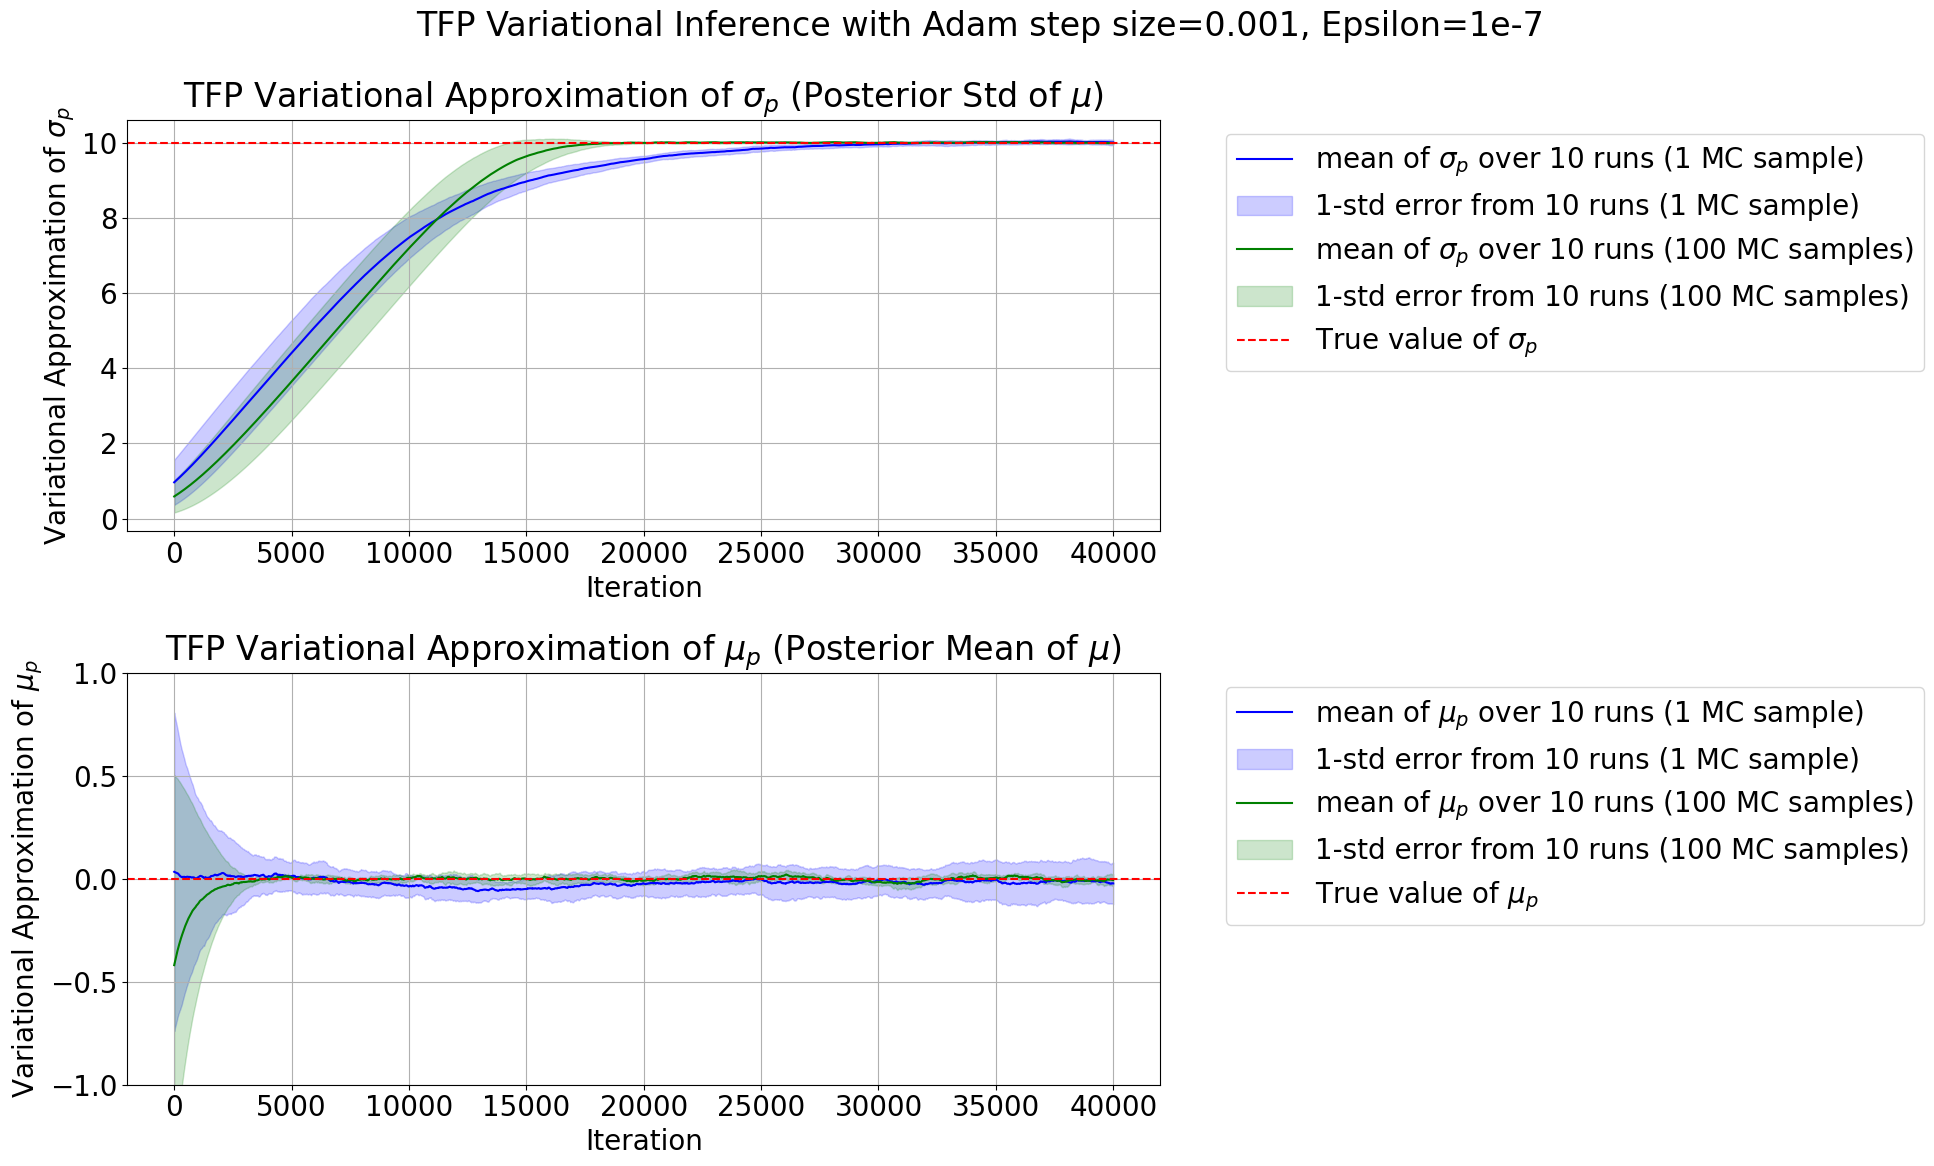

In [35]:
fig, axs = plt.subplots(2, 1, figsize=(20, 12))

# set font size to 14
plt.rcParams.update({'font.size': 20})
# plot a summary of all 10 single sample runs as one line with error bars
axs[1].plot(
    mean_single_means,
    label=r'mean of $\mu_p$ over 10 runs (1 MC sample)',
    color='blue'
)
# plot the error bar
axs[1].fill_between(
    np.arange(len(mean_single_means)),
    mean_single_means - std_single_means,
    mean_single_means + std_single_means,
    color='blue',
    alpha=0.2,
    label='1-std error from 10 runs (1 MC sample)'
)
# plot a summary of all 10 multi sample runs as one line with error bars
axs[1].plot(
    mean_multi_means,
    label=r'mean of $\mu_p$ over 10 runs (100 MC samples)',
    color='green'
)
# plot the error bar
axs[1].fill_between(
    np.arange(len(mean_multi_means)),
    mean_multi_means - std_multi_means,
    mean_multi_means + std_multi_means,
    color='green',
    alpha=0.2,
    label='1-std error from 10 runs (100 MC samples)'
)
axs[1].axhline(mu_prior, color='red', linestyle='--', label=r'True value of $\mu_p$')
axs[1].set_title(r'TFP Variational Approximation of $\mu_p$ (Posterior Mean of $\mu$)')
axs[1].set_xlabel('Iteration')
axs[1].set_ylabel(r'Variational Approximation of $\mu_p$')
axs[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
axs[1].grid()

axs[0].plot(
    mean_single_stds,
    label=r'mean of $\sigma_p$ over 10 runs (1 MC sample)',
    color='blue'
)
# plot the error bar
axs[0].fill_between(
    np.arange(len(mean_single_stds)),
    mean_single_stds - std_single_stds,
    mean_single_stds + std_single_stds,
    color='blue',
    alpha=0.2,
    label='1-std error from 10 runs (1 MC sample)'
)
# plot a summary of all 10 multi sample runs as one line with error bars
axs[0].plot(
    mean_multi_stds,
    label=r'mean of $\sigma_p$ over 10 runs (100 MC samples)',
    color='green'
)
# plot the error bar
axs[0].fill_between(
    np.arange(len(mean_multi_stds)),
    mean_multi_stds - std_multi_stds,
    mean_multi_stds + std_multi_stds,
    color='green',
    alpha=0.2,
    label='1-std error from 10 runs (100 MC samples)'
)
axs[0].axhline(sigma_prior, color='red', linestyle='--', label=r'True value of $\sigma_p$')
axs[0].set_title(r'TFP Variational Approximation of $\sigma_p$ (Posterior Std of $\mu$)')
axs[0].set_xlabel('Iteration', fontsize=20)
axs[0].set_ylabel(r'Variational Approximation of $\sigma_p$')
# legend to right outside
axs[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
axs[0].grid()
# axs[0].set_ylim(sigma_prior - 1, sigma_prior + 2)
axs[1].set_ylim(mu_prior - 1, mu_prior + 1)

plt.suptitle('TFP Variational Inference with Adam step size=0.001, Epsilon=1e-7', fontsize=24)

plt.tight_layout()
plt.show()

Now let's do it 10 times but at the numpyro default values.

In [19]:
q_z_0_1_n = return_trainable()
q_z_0_100_n = return_trainable()
losses_0_1_n = fit_tfp_model(0, q_z_0_1_n, adam_learning_rate=1e-2, adam_epsilon=1e-8)
losses_0_100_n = fit_tfp_model(0, q_z_0_100_n, sample_size=100, adam_learning_rate=1e-2, adam_epsilon=1e-8)

q_z_1_1_n = return_trainable()
q_z_1_100_n = return_trainable()

losses_1_1_n = fit_tfp_model(1, q_z_1_1_n, adam_learning_rate=1e-2, adam_epsilon=1e-8)
losses_1_100_n = fit_tfp_model(1, q_z_1_100_n, sample_size=100, adam_learning_rate=1e-2, adam_epsilon=1e-8)

q_z_2_1_n = return_trainable()
q_z_2_100_n = return_trainable()
losses_2_1_n = fit_tfp_model(2, q_z_2_1_n, adam_learning_rate=1e-2, adam_epsilon=1e-8)
losses_2_100_n = fit_tfp_model(2, q_z_2_100_n, sample_size=100, adam_learning_rate=1e-2, adam_epsilon=1e-8)


q_z_3_1_n = return_trainable()
q_z_3_100_n = return_trainable()

losses_3_1_n = fit_tfp_model(3, q_z_3_1_n, adam_learning_rate=1e-2, adam_epsilon=1e-8)
losses_3_100_n = fit_tfp_model(3, q_z_3_100_n, sample_size=100, adam_learning_rate=1e-2, adam_epsilon=1e-8)

q_z_4_1_n = return_trainable()
q_z_4_100_n = return_trainable()
losses_4_1_n = fit_tfp_model(4, q_z_4_1_n, adam_learning_rate=1e-2, adam_epsilon=1e-8)
losses_4_100_n = fit_tfp_model(4, q_z_4_100_n, sample_size=100, adam_learning_rate=1e-2, adam_epsilon=1e-8)

q_z_5_1_n = return_trainable()
q_z_5_100_n = return_trainable()
losses_5_1_n = fit_tfp_model(5, q_z_5_1_n, adam_learning_rate=1e-2, adam_epsilon=1e-8)
losses_5_100_n = fit_tfp_model(5, q_z_5_100_n, sample_size=100, adam_learning_rate=1e-2, adam_epsilon=1e-8)

q_z_6_1_n = return_trainable()
q_z_6_100_n = return_trainable()
losses_6_1_n = fit_tfp_model(6, q_z_6_1_n, adam_learning_rate=1e-2, adam_epsilon=1e-8)
losses_6_100_n = fit_tfp_model(6, q_z_6_100_n, sample_size=100, adam_learning_rate=1e-2, adam_epsilon=1e-8)

q_z_7_1_n = return_trainable()
q_z_7_100_n = return_trainable()
losses_7_1_n = fit_tfp_model(7, q_z_7_1_n, adam_learning_rate=1e-2, adam_epsilon=1e-8)
losses_7_100_n = fit_tfp_model(7, q_z_7_100_n, sample_size=100, adam_learning_rate=1e-2, adam_epsilon=1e-8)

q_z_8_1_n = return_trainable()
q_z_8_100_n = return_trainable()
losses_8_1_n = fit_tfp_model(8, q_z_8_1_n, adam_learning_rate=1e-2, adam_epsilon=1e-8)
losses_8_100_n = fit_tfp_model(8, q_z_8_100_n, sample_size=100, adam_learning_rate=1e-2, adam_epsilon=1e-8)

q_z_9_1_n = return_trainable()
q_z_9_100_n = return_trainable()
losses_9_1_n = fit_tfp_model(9, q_z_9_1_n, adam_learning_rate=1e-2, adam_epsilon=1e-8)
losses_9_100_n = fit_tfp_model(9, q_z_9_100_n, sample_size=100, adam_learning_rate=1e-2, adam_epsilon=1e-8)

In [25]:
# compile all single sample runs into one array
single_runs_means_n = np.array([
    losses_0_1_n[0],
    losses_1_1_n[0],
    losses_2_1_n[0],
    losses_3_1_n[0],
    losses_4_1_n[0],
    losses_5_1_n[0],
    losses_6_1_n[0],
    losses_7_1_n[0],
    losses_8_1_n[0],
    losses_9_1_n[0],
])
mean_single_means_n = np.mean(single_runs_means_n, axis=0)
std_single_means_n = np.std(single_runs_means_n, axis=0)

multi_runs_means_n = np.array([
    losses_0_100_n[0],
    losses_1_100_n[0],
    losses_2_100_n[0],
    losses_3_100_n[0],
    losses_4_100_n[0],
    losses_5_100_n[0],
    losses_6_100_n[0],
    losses_7_100_n[0],
    losses_8_100_n[0],
    losses_9_100_n[0],
])
mean_multi_means_n = np.mean(multi_runs_means_n, axis=0)
std_multi_means_n = np.std(multi_runs_means_n, axis=0) 

single_runs_stds_n = np.array([
    losses_0_1_n[1],
    losses_1_1_n[1],
    losses_2_1_n[1],
    losses_3_1_n[1],
    losses_4_1_n[1],
    losses_5_1_n[1],
    losses_6_1_n[1],
    losses_7_1_n[1],
    losses_8_1_n[1],
    losses_9_1_n[1],
])
mean_single_stds_n = np.mean(single_runs_stds_n, axis=0)
std_single_stds_n = np.std(single_runs_stds_n, axis=0)

multi_runs_stds_n = np.array([
    losses_0_100_n[1],
    losses_1_100_n[1],
    losses_2_100_n[1],
    losses_3_100_n[1],
    losses_4_100_n[1],
    losses_5_100_n[1],
    losses_6_100_n[1],
    losses_7_100_n[1],
    losses_8_100_n[1],
    losses_9_100_n[1],
])
mean_multi_stds_n = np.mean(multi_runs_stds_n, axis=0)
std_multi_stds_n = np.std(multi_runs_stds_n, axis=0)

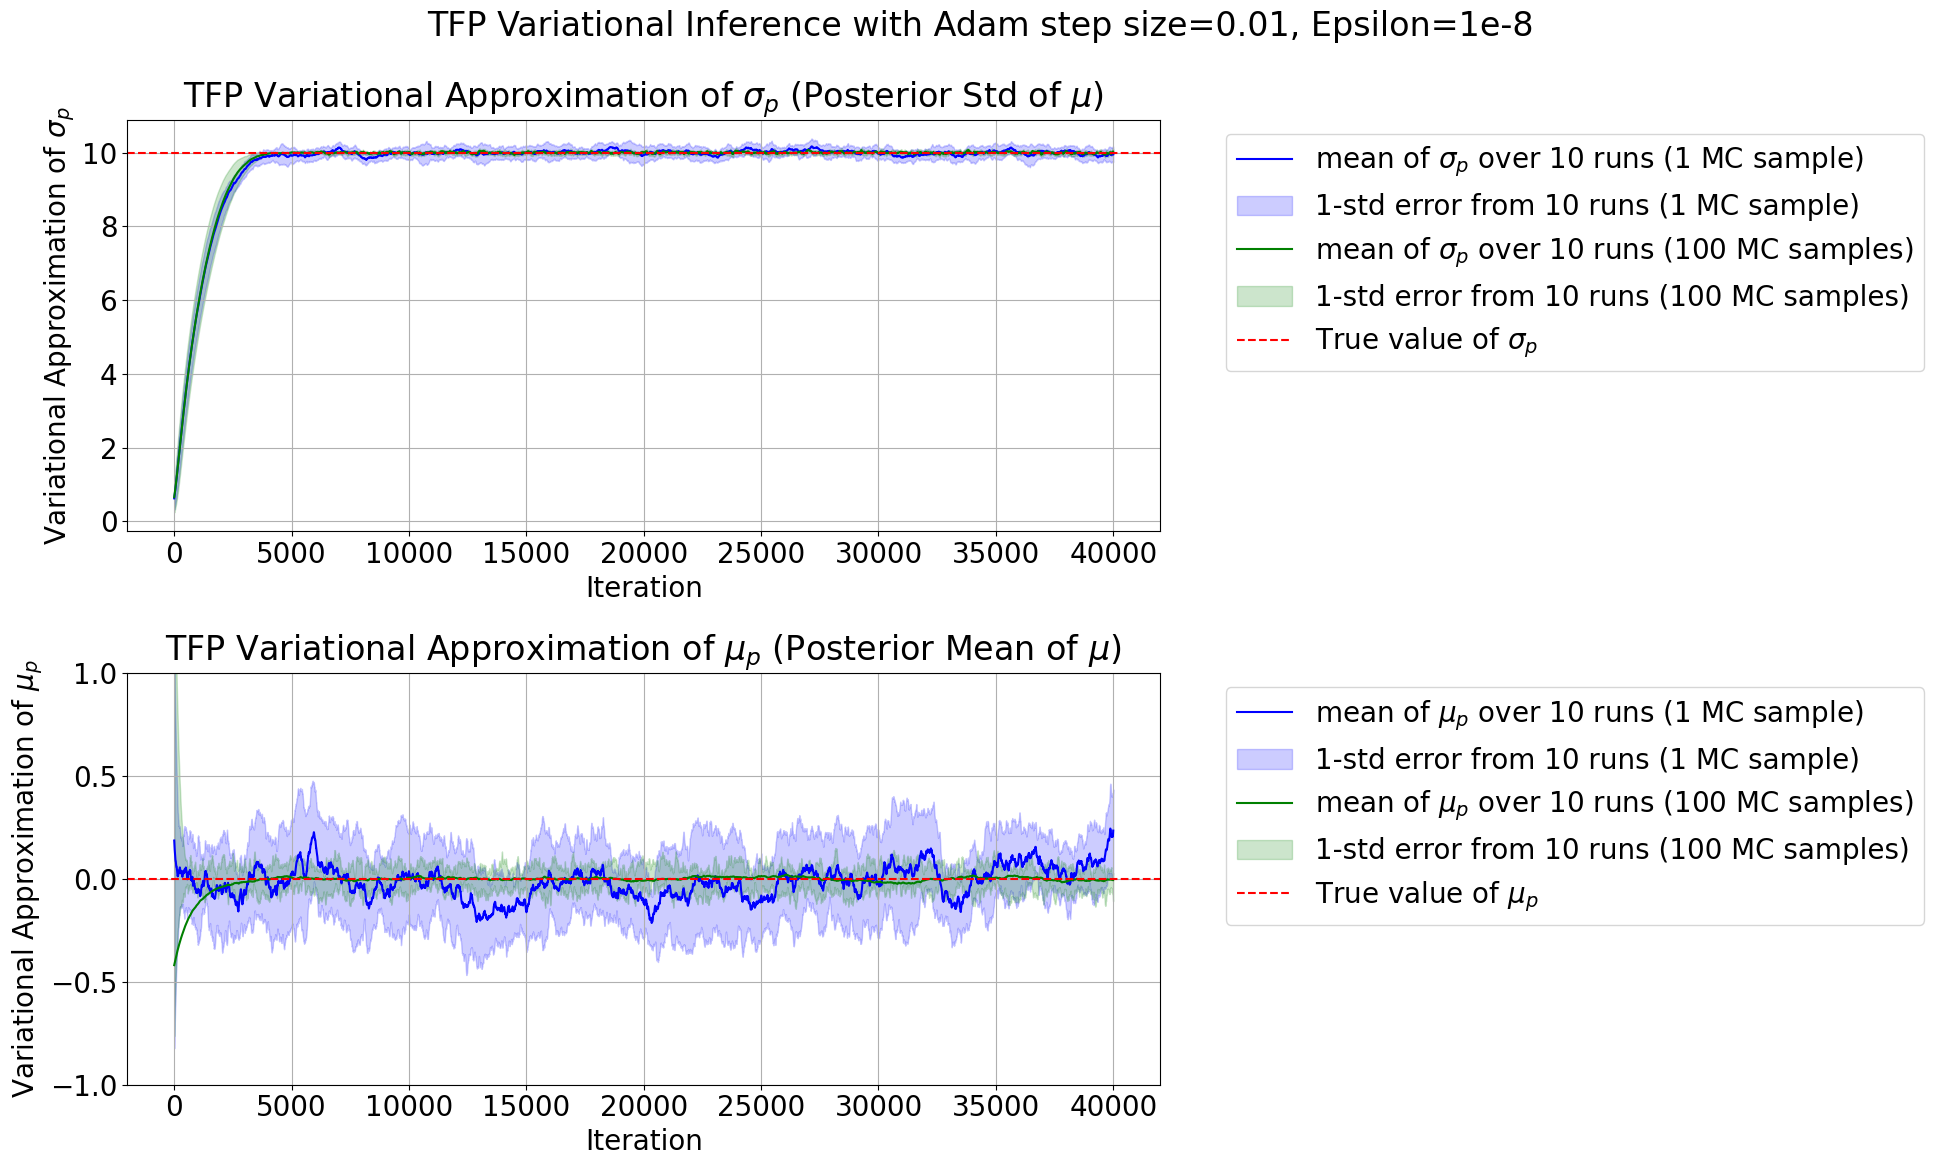

In [34]:
fig, axs = plt.subplots(2, 1, figsize=(20, 12))

# set font size to 14
plt.rcParams.update({'font.size': 20})
# plot a summary of all 10 single sample runs as one line with error bars
axs[1].plot(
    mean_single_means_n,
    label=r'mean of $\mu_p$ over 10 runs (1 MC sample)',
    color='blue'
)
# plot the error bar
axs[1].fill_between(
    np.arange(len(mean_single_means_n)),
    mean_single_means_n - std_single_means_n,
    mean_single_means_n + std_single_means_n,
    color='blue',
    alpha=0.2,
    label='1-std error from 10 runs (1 MC sample)'
)
# plot a summary of all 10 multi sample runs as one line with error bars
axs[1].plot(
    mean_multi_means,
    label=r'mean of $\mu_p$ over 10 runs (100 MC samples)',
    color='green'
)
# plot the error bar
axs[1].fill_between(
    np.arange(len(mean_multi_means_n)),
    mean_multi_means_n - std_multi_means_n,
    mean_multi_means_n + std_multi_means_n,
    color='green',
    alpha=0.2,
    label='1-std error from 10 runs (100 MC samples)'
)
axs[1].axhline(mu_prior, color='red', linestyle='--', label=r'True value of $\mu_p$')
axs[1].set_title(r'TFP Variational Approximation of $\mu_p$ (Posterior Mean of $\mu$)')
axs[1].set_xlabel('Iteration')
axs[1].set_ylabel(r'Variational Approximation of $\mu_p$')
axs[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
axs[1].grid()

axs[0].plot(
    mean_single_stds_n,
    label=r'mean of $\sigma_p$ over 10 runs (1 MC sample)',
    color='blue'
)
# plot the error bar
axs[0].fill_between(
    np.arange(len(mean_single_stds_n)),
    mean_single_stds_n - std_single_stds_n,
    mean_single_stds_n + std_single_stds_n,
    color='blue',
    alpha=0.2,
    label='1-std error from 10 runs (1 MC sample)'
)
# plot a summary of all 10 multi sample runs as one line with error bars
axs[0].plot(
    mean_multi_stds_n,
    label=r'mean of $\sigma_p$ over 10 runs (100 MC samples)',
    color='green'
)
# plot the error bar
axs[0].fill_between(
    np.arange(len(mean_multi_stds_n)),
    mean_multi_stds_n - std_multi_stds_n,
    mean_multi_stds_n + std_multi_stds_n,
    color='green',
    alpha=0.2,
    label='1-std error from 10 runs (100 MC samples)'
)
axs[0].axhline(sigma_prior, color='red', linestyle='--', label=r'True value of $\sigma_p$')
axs[0].set_title(r'TFP Variational Approximation of $\sigma_p$ (Posterior Std of $\mu$)')
axs[0].set_xlabel('Iteration', fontsize=20)
axs[0].set_ylabel(r'Variational Approximation of $\sigma_p$')
# legend to right outside
axs[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
axs[0].grid()
# axs[0].set_ylim(sigma_prior - 1, sigma_prior + 2)
axs[1].set_ylim(mu_prior - 1, mu_prior + 1)

plt.suptitle('TFP Variational Inference with Adam step size=0.01, Epsilon=1e-8', fontsize=24)
plt.tight_layout()
plt.show()